## Demonstration of equivalence of weighted-beta and predicted time-series evaluation 
This notebook tests (by simulation) different ways of evaluating connectivity models. 

Because we have different regressors (intruction, and condition-related regressors of different length), the best way would be to evaluate on the predicted time series - of course subtracting out the mean of the time series. 

To achive this is a computationally efficient manner, we play the following trick: The reconstructed (task-related) time series is:

$$ \mathbf{Y} = \mathbf{X} \boldsymbol{\beta}$$ 

The cosine similarity is then 
$$ r = \frac{\mathbf{Y}^T \hat{\mathbf{Y}}}{\sqrt{\mathbf{Y}^T\mathbf{Y}}\sqrt{\hat{\mathbf{Y}}^T\hat{\mathbf{Y}}}}$$

So we can just calculate the dot product of the observed by predicted and observed time series: 

$$ \mathbf{Y}^T \hat{\mathbf{Y}}  = \boldsymbol{\beta}^T\mathbf{X}^T \mathbf{X} \hat{\boldsymbol{\beta}}$$

By Introducing a weighting matrix, which can be smaller than the original design matrix (using scipy.linalg.sqrtm)

$$ \mathbf{W}\mathbf{W} = \mathbf{X}.T\mathbf{X}$$ 

and to the inner product of the weight beta-coefficients: 
$$ \boldsymbol{\beta}^T\mathbf{W}^T \mathbf{W} \hat{\boldsymbol{\beta}}$$

The other terms of the cosine similartity can also be computed from the weighted betas. This trick also works for the R2 measure, it is also depends on the quadrative forms above. 

Note that the mean of the weighted betas: 

$$ \boldsymbol{\beta}_w = \mathbf{W}\boldsymbol{\beta}$$ 
is not zero - even though they represent a mean-centered time-series. So Cosine-similarity and R2 calculation should not subtract the mean of the beta (or weighted beta) coefficients. 

In [66]:
import numpy as np 
from scipy.io import loadmat 
import seaborn as sb
import matplotlib.pyplot as plt
from numpy.linalg import pinv
from scipy.linalg import sqrtm # Any matrix decomposition will work (Cholesky), but sqrtm is symmetric
import connectivity.evaluation as ev # Evaluation routine 

(598, 46)

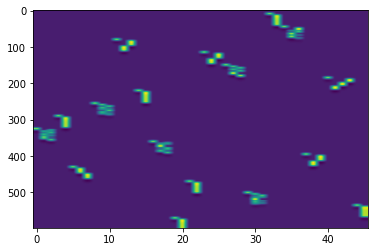

In [67]:
# Load an example design matrix with instruction and condition regressors
F = loadmat('designmatrix.mat')
X = F['X']
plt.imshow(X,aspect='auto')
X.shape

In [68]:
# Generate example data for a single voxel  
N = X.shape[0] # Number of time points 
K = 5 # Number of runs
beta = np.random.normal(1,1,(46,1)) # Note that the beta weights are mostly postive 
Ytrue = X @ beta
Y = np.random.normal(0,10,(N,K)) + Ytrue # Generate raw data 

In [69]:
# Now estimate back the regression coefficients using OLS regression 
# Of course, SPM uses GLS with covariance weighting, but we are skipping this here
Xall = np.c_[X,np.ones((N,))] # Add intercept to the design matrix 
beta_hat = pinv(Xall) @ Y        # OLS regression  
beta_hat = beta_hat[:-1,:]      # Drop intercept 

In [70]:
# Ideally we would like to do the evaluation on the predicted time series - mean subtracted 
Xm = X - X.mean(axis = 0) # Remove the mean from each of the regressors 
Ytrue = Xm @ beta   # This is the true time series 
Ytask = Xm @ beta_hat # Task-related time-series from the fit 
_,R1 = ev.calculate_R(Ytask,Ytrue)
print(f'R timeseries: {R1.round(3)}')


R timeseries: [0.357 0.298 0.126 0.496 0.53 ]


In [71]:
# This is the beta-only approach without subtracting mean of betas 
_,R2 = ev.calculate_R(beta_hat,beta)
print(f'R beta w  mean:{R2.round(3)}')

R beta w  mean:[0.77  0.68  0.706 0.834 0.61 ]


In [72]:
# Now do beta with mean-substraction 
beta_hat_m = beta_hat-beta_hat.mean(axis = 0)
beta_m = beta-beta.mean(axis = 0)
                                   
_,R3 = ev.calculate_R(beta_hat_m,beta_m)
print(f'R beta wo mean:{R3.round(3)}')

R beta wo mean:[0.291 0.337 0.141 0.483 0.374]


In [73]:
# Instead do weighting - As you can confirm - this is identical to the predicted time series 
W = sqrtm(Xm.T @ X)
beta_hat_w = W @ beta_hat
beta_w     = W @ beta

_,R4 = ev.calculate_R(beta_hat_w,beta_w)
print(f'R beta weighted:{R4.round(3)}')

R beta weighted:[0.357 0.298 0.126 0.496 0.53 ]


In [75]:
# This trick also works for the R2-value: 
_,R21 = ev.calculate_R2(Ytask,Ytrue)
print(f'R timeseries:   {R21.round(3)}')
_,R22 = ev.calculate_R2(beta_hat,beta)
print(f'R beta w  mean: {R22.round(3)}')
_,R23 = ev.calculate_R2(beta_hat_m,beta_m)
print(f'R beta wo mean: {R23.round(3)}')
_,R24 = ev.calculate_R2(beta_hat_w,beta_w)
print(f'R beta weighted:{R24.round(3)}')

R timeseries:   [ 0.126  0.088 -0.004  0.216  0.248]
R beta w  mean: [0.28  0.299 0.245 0.291 0.326]
R beta wo mean: [0.082 0.1   0.014 0.17  0.131]
R beta weighted:[ 0.126  0.088 -0.004  0.216  0.248]
